In [0]:
!pip install ggplot
from __future__ import print_function
%matplotlib inline

from IPython.display import Image, display
from io import BytesIO
import matplotlib.pyplot as plt

import os
from os.path import join, exists
import sys
import numpy as np
import time

import urllib2
import json
from zipfile import ZipFile

import pandas as pd
import pydot_ng as pydot
import graphviz
from ggplot import *

import tensorflow as tf

from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.data_utils import get_file
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, Model, load_model
from keras.layers import Embedding, Dense, Input, Dropout, Reshape, BatchNormalization, TimeDistributed, Lambda, Layer, LSTM, Bidirectional, Convolution1D, GRU, add, concatenate
from keras.callbacks import Callback, ModelCheckpoint, TensorBoard, BaseLogger, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam, SGD, Adagrad

In [0]:
training_sample_size = 1000 # Change this to -1 if you want all
max_seq_length = 20 # max 400

model_name = 'small'

lr = 0.001
lr_decay = 1e-4
epochs = 10
batch_size = 32


## Download GloVe

In [0]:
glove_url = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
embedding_dim = 300
glove_filename = 'glove.840B.' + str(embedding_dim) + 'd.zip'
glove_loc = join(glove_filename)

if not exists(glove_loc):
    print('Download %s' % glove_filename)
    get_file(glove_filename, glove_url, cache_dir='.', extract=True)


Download glove.840B.300d.zip
2176778240/2176768927 [==============================] - 613s 0us/step


In [0]:
glove_filename = os.path.join("datasets", 'glove.840B.300d.txt')

embeddings = {}

print('Extract %s' % glove_filename)
with open(glove_filename, 'r') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings[word] = embedding
        
print('Embeddings size: %d' % len(embeddings))

Extract datasets/glove.840B.300d.txt
Embeddings size: 2196016


##**Loading Dataset**

In [0]:
def readFile(fileName):
  data = pd.read_csv(fileName, delimiter='\t', header = None, skiprows=1)
  data.columns = ["pair_ID", "sentence_A", "sentence_B", "relatedness_score", "entailment_judgment"]
  return data

In [0]:
train = readFile('SICK_train.txt')
test = readFile('SICK_test_annotated.txt')
valid = readFile('SICK_trial.txt')

In [0]:
train_df_features = train[['sentence_A','sentence_B']]
textsValid = valid[['sentence_A','sentence_B']]


In [0]:
labels = train["relatedness_score"]

labelsValid = valid["relatedness_score"]

textsTest = test[['sentence_A','sentence_B']]
labelsTest = test["relatedness_score"]


In [0]:
train_sentence1 = train['sentence_A'].values.tolist()
train_sentence2 = train['sentence_B'].values.tolist()

valid_sentence1 = valid['sentence_A'].values.tolist()
valid_sentence2 = valid['sentence_B'].values.tolist()

## **Normalizing Target Value**

In [0]:
from sklearn.preprocessing import MinMaxScaler

q = np.reshape(labels, (-1,1))
scaler = MinMaxScaler()
scaler.fit(q)
labels = pd.DataFrame(scaler.transform(q))

w = np.reshape(labelsValid, (-1,1))
scaler1 = MinMaxScaler()
scaler1.fit(w)
labelsValid = pd.DataFrame(scaler1.transform(w))

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


## Prepare Word Embeddings

In [0]:
NUM_WORDS = len(embeddings) #200000

print('Found %s samples.' % len(train_sentence1))

train_sentences = train_sentence1 + train_sentence2
valid_sentences = valid_sentence1 + valid_sentence2


tokenizer = Tokenizer(num_words = NUM_WORDS)
tokenizer.fit_on_texts(train_sentences)

sentence1_word_sequences = tokenizer.texts_to_sequences(train_sentence1)
sentence2_word_sequences = tokenizer.texts_to_sequences(train_sentence2)

valid_sentence1_word_sequences = tokenizer.texts_to_sequences(valid_sentence1)
valid_sentence2_word_sequences = tokenizer.texts_to_sequences(valid_sentence2)


word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 4500 samples.
Found 2184 unique tokens.


In [0]:
from collections import defaultdict
embedding_dim = 300
words_len = min(NUM_WORDS, len(word_index))
# word_embedding_matrix = np.zeros((words_len + 1, embedding_dim))
word_embedding_matrix = np.random.random((words_len + 1, embedding_dim))
k = 0
for word, i in word_index.items():
    if i >= NUM_WORDS:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector
        k += 1
        
max_word_count_text = 0
text_count = defaultdict(int)
for sentence in sentence1_word_sequences:
    max_word_count_text = max(max_word_count_text, len(sentence))
    text_count[len(sentence)] += 1

max_word_count_hypo = 0
hypo_count = defaultdict(int)
for sentence in sentence2_word_sequences:
    max_word_count_hypo = max(max_word_count_hypo, len(sentence))
    hypo_count[len(sentence)] += 1
        

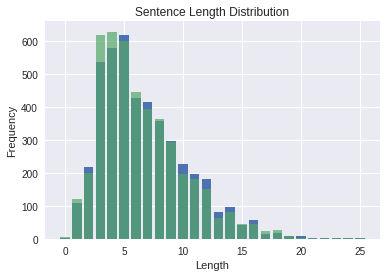

In [0]:

mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

ax.bar(range(len(text_count)), text_count.values())
ax.bar(range(len(hypo_count)), hypo_count.values(), alpha=0.7)

plt.title("Sentence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

In [0]:
print('Null word embeddings: %d' % (np.sum(np.sum(word_embedding_matrix, axis=1) == 0) - 1))
print('Found %d' % k)
print('Total: %d' % len(word_embedding_matrix))
print('Max word text: %d' % max_word_count_text)
print('Max word hypothesis: %d' % max_word_count_hypo)

Null word embeddings: -1
Found 2163
Total: 2185
Max word text: 28
Max word hypothesis: 32


In [0]:
s1_data = pad_sequences(sentence1_word_sequences, maxlen = max_seq_length)
s2_data = pad_sequences(sentence2_word_sequences, maxlen = max_seq_length)
s1_dataValid = pad_sequences(valid_sentence1_word_sequences, maxlen = max_seq_length)
s2_dataValid = pad_sequences(valid_sentence2_word_sequences, maxlen = max_seq_length)


#labels = np_utils.to_categorical(le.fit_transform(train["entailment_judgment"].values)).astype("int64")
#labelsValid = np_utils.to_categorical(le.fit_transform(valid["entailment_judgment"].values)).astype("int64")



print('Shape of sentence1 tensor:', s1_data.shape)
print('Shape of sentence2 tensor:', s2_data.shape)
print('Shape of label tensor:', labels.shape)

Shape of sentence1 tensor: (4500, 20)
Shape of sentence2 tensor: (4500, 20)
Shape of label tensor: (4500, 1)


In [0]:
print('One sample')

print('Text: ')
print( train_sentence1[0] )

print('Word sequence: ')
print( sentence1_word_sequences[0] )

print('Pad: ')
print( s1_data[0] )

One sample
Text: 
A group of kids is playing in a yard and an old man is standing in the background
Word sequence: 
[1, 63, 10, 114, 2, 12, 5, 1, 212, 6, 19, 271, 4, 2, 21, 5, 3, 213]
Pad: 
[  0   0   1  63  10 114   2  12   5   1 212   6  19 271   4   2  21   5
   3 213]


## Helper methods.

In [0]:
eps = 1e-6

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def cosine_distance(y1, y2):
    mult =  tf.multiply(y1, y2)
    cosine_numerator = tf.reduce_sum( mult, axis = -1)
    y1_norm = tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(y1), axis=-1 ), eps) ) 
    y2_norm = tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(y2), axis=-1 ), eps) ) 
    return cosine_numerator / y1_norm / y2_norm

def cal_relevancy_matrix(text_vector, hypo_vector):
    text_vector_tmp = tf.expand_dims(text_vector, 1) # [batch_size, 1, question_len, dim]
    hypo_vector_tmp = tf.expand_dims(hypo_vector, 2) # [batch_size, passage_len, 1, dim]
    relevancy_matrix = cosine_distance(text_vector_tmp, hypo_vector_tmp) # [batch_size, passage_len, question_len]
    return relevancy_matrix

def mask_relevancy_matrix(relevancy_matrix, text_mask, hypo_mask):
    relevancy_matrix = tf.multiply(relevancy_matrix, K.expand_dims(text_mask, 1))
    relevancy_matrix = tf.multiply(relevancy_matrix, K.expand_dims(hypo_mask, 2))
    return relevancy_matrix

def max_mean_pooling(repres, cosine_matrix):
    
    repres.append(tf.reduce_max(cosine_matrix, axis = 2, keep_dims = True))
    repres.append(tf.reduce_mean(cosine_matrix, axis = 2, keep_dims = True))

    return repres

def matching_layer(inputs):
    forward_relevancy_matrix = cal_relevancy_matrix(inputs[0], inputs[2])
    backward_relevancy_matrix = cal_relevancy_matrix(inputs[1], inputs[3])

    representation = []

    max_mean_pooling(representation, forward_relevancy_matrix)
    max_mean_pooling(representation, backward_relevancy_matrix)
    
    return representation

## Matching layer

In [0]:
class MatchLayer(Layer):

    def __init__(self, dim, seq_length, **kwargs):
        super(MatchLayer, self).__init__(**kwargs)
        self.supports_masking = True
        self.dim = dim
        self.seq_length = seq_length
        
    def build(self, input_shape):
        if not isinstance(input_shape, list):
            raise ValueError('`MatchLayer` layer should be called '
                             'on a list of inputs')
        
        if all([shape is None for shape in input_shape]):
            return
        
        super(MatchLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, inputs):
        if not isinstance(inputs, list):
            raise ValueError('A `MatchLayer` layer should be called ')
        
        return matching_layer(inputs)
    
    def compute_output_shape(self, input_shape):
        if not isinstance(input_shape, list):
            raise ValueError('A `MatchLayer` layer should be called '
                             'on a list of inputs.')
        
        input_shapes = input_shape
        output_shape = list(input_shapes[0])
                             
        return [ (None, output_shape[1] , 1) ] * 4 
    
    def get_config(self):
        config = {

        }
        base_config = super(MatchLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
class MaxPoolingLayer(Layer):

    def __init__(self, **kwargs):
        super(MaxPoolingLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        super(MaxPoolingLayer, self).build(input_shape)
    
    def call(self, inputs):
        return max_mean_pooling([], inputs)
    
    def compute_output_shape(self, input_shape):            
        output_shape = list(input_shape)
        return [ (None, output_shape[1] , 1) ] * 2
    
    def compute_mask(self, inputs, mask):
        return [mask, mask]


In [0]:
models = {};

def word_context(input, name):
    embedding = Embedding(words_len + 1,
                     embedding_dim,
                     weights = [word_embedding_matrix],
                     input_length = max_seq_length,
                     trainable = False,
                     name = name + '_embedding')(input)
    
    word = Dropout(0.1)(embedding)

    context = Bidirectional(LSTM(100, return_sequences = True),
                            merge_mode = None,
                            name = name + '_context')(word)
    
    return (word, context)

def create_model():
    
    sentence1_input = Input(shape=(max_seq_length,), dtype='int32', name = 'text')
    sentence2_input = Input(shape=(max_seq_length,), dtype='int32', name = 'hypothesis')
    
    (text_embedding, text_context) = word_context(sentence1_input, 'text')
    (hypo_embedding, hypo_context) = word_context(sentence2_input, 'hypothesis')

    left_context = []
    left_context.extend(hypo_context)
    left_context.extend(text_context)
    
    left_match = MatchLayer(embedding_dim, max_seq_length)( left_context )
    
    right_context = []
    right_context.extend(text_context)
    right_context.extend(hypo_context)
    
    right_match = MatchLayer(embedding_dim, max_seq_length)( right_context )
    
    cosine_left = Lambda(lambda x_input: cal_relevancy_matrix(x_input[0], x_input[1]))( [text_embedding, hypo_embedding] )
    cosine_right = Lambda(lambda cosine: tf.transpose(cosine, perm=[0,2,1]))( cosine_left )
    
    left_representation = MaxPoolingLayer()( cosine_left )
    right_representation = MaxPoolingLayer()( cosine_right )
    
    left_representation.extend( left_match )
    right_representation.extend( right_match ) 
    
    left = concatenate(left_representation, axis = 2)
    left = Dropout(0.1)(left)
    
    right = concatenate(right_representation, axis = 2)
    right = Dropout(0.1)(right)
    

    aggregation_left = Bidirectional(LSTM(100),
                            name = 'aggregation_text_context')(left)
    
    aggregation_right = Bidirectional(LSTM(100),
                            name = 'aggregation_hypo_context')(right)
    
    aggregation = concatenate([aggregation_left, aggregation_right], axis = -1)
                               
    pred = Dense(200, activation = 'tanh', name = 'tanh_prediction')(aggregation)
    pred = Dense(1, activation = 'sigmoid', name = 'sigmoid_prediction')(pred)
    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    model = Model(inputs=[sentence1_input, sentence2_input], outputs = pred)
    model.compile(loss = 'mean_squared_error', 
              optimizer = optimizer,
              metrics = ['mse'])
    
    print('Model created')
    
    return model


models['adam'] = create_model()



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Model created


## Train Model

In [0]:

results = []
for name, model in models.items():
    callbacks = [
        BaseLogger(),
        ReduceLROnPlateau(monitor = 'val_loss', factor=0.2, patience=5, min_lr=0.001),
        TensorBoard(log_dir='./' + model_name + '-' + name + '-logs', histogram_freq=0, write_graph=True, write_images=True),
        ModelCheckpoint(model_name + '-' + name + '-checkpoint-weights.{epoch:02d}-{val_mean_squared_error:.2f}.hdf5', monitor='val_mean_squared_error', save_best_only=True)
    ]
    
    start_time = time.time()
    print('')
    print('Start learning %s at %d' % (name, start_time))
    print('Epochs: %d' % epochs)
    print('Batch size: %d' % batch_size)

    history = model.fit([s1_data, s2_data],
                        labels,
                        epochs = 10,
                        batch_size = batch_size,
                        validation_data=([s1_dataValid, s2_dataValid], labelsValid),
                        shuffle = True, #True,
                        verbose = 2,
                        callbacks = callbacks)

    model.save(model_name + '-' + name + '-model.h5')
    model.save_weights(model_name + '-' + name + '-weights.h5')

    end_time = time.time()
    average_time_per_epoch = (end_time - start_time) / epochs
    results.append((history, average_time_per_epoch))
    
    print('Time: %d' % (end_time - start_time))


Start learning adam at 1553233953
Epochs: 10
Batch size: 32
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 4500 samples, validate on 500 samples
Epoch 1/10
 - 45s - loss: 0.0539 - mean_squared_error: 0.0539 - val_loss: 0.0378 - val_mean_squared_error: 0.0378
Epoch 2/10
 - 38s - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 3/10
 - 38s - loss: 0.0324 - mean_squared_error: 0.0324 - val_loss: 0.0339 - val_mean_squared_error: 0.0339
Epoch 4/10
 - 38s - loss: 0.0256 - mean_squared_error: 0.0256 - val_loss: 0.0322 - val_mean_squared_error: 0.0322
Epoch 5/10
 - 38s - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0358 - val_mean_squared_error: 0.0358
Epoch 6/10
 - 38s - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 7/10
 - 38s - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0378 -

# Testing


In [0]:
test_s1_word_sequences = tokenizer.texts_to_sequences(test['sentence_A'].values.tolist())
test_s2_word_sequences = tokenizer.texts_to_sequences(test['sentence_B'].values.tolist())

test_s1_data = pad_sequences(test_s1_word_sequences, maxlen = max_seq_length)
test_s2_data = pad_sequences(test_s2_word_sequences, maxlen = max_seq_length)
test_labels = test["relatedness_score"]

print('Shape of test sentence1 tensor:', test_s1_data.shape)
print('Shape of test sentence2 tensor:', test_s2_data.shape)
print('Shape of test label tensor:', test_labels.shape)

Shape of test sentence1 tensor: (4927, 20)
Shape of test sentence2 tensor: (4927, 20)
Shape of test label tensor: (4927,)


In [0]:
e = np.reshape(test_labels, (-1,1))
scaler1 = MinMaxScaler()
scaler1.fit(e)
test_labels = pd.DataFrame(scaler1.transform(e))

In [0]:
for name, model in models.items():
    print('')
    print('Model %s' % name)
    
    test_pred = model.predict([test_s1_data, test_s2_data], batch_size=128)
    



Model adam


In [0]:
output= list()
for x in test_pred:
  output.append(x[0])

test["Actual Output"] = output
test["normalized label"] = labelsTest
test.to_excel("output.xlsx")

In [0]:
import numpy
numpy.corrcoef(test['normalized label'], test['Actual Output'])[0, 1]


0.7249025097246602

In [0]:
# calculate the spearman's correlation between two variables
from numpy.random import rand
from numpy.random import seed
from scipy.stats import spearmanr
# seed random number generator
seed(1)

# calculate spearman's correlation
coef, p = spearmanr(test['normalized label'], test['Actual Output'])
print('Spearmans correlation coefficient: %.3f' % coef)
print('p: %.3f' % p)

Spearmans correlation coefficient: 0.661
p: 0.000


In [0]:
output = np.reshape(test['Actual Output'], (-1,1))

scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(abc)
output = pd.DataFrame(scaler.transform(abc))


In [0]:
output


,0
0,2.678849
1,4.292381
2,3.160466
3,4.654096
4,4.639315
5,3.631471
6,3.310823
7,2.780419
8,2.872915
9,4.448955
